In [12]:
import numpy as np
import pandas as pd
import seaborn as sb
from torch.optim import SGD, Adam
from tqdm import trange
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

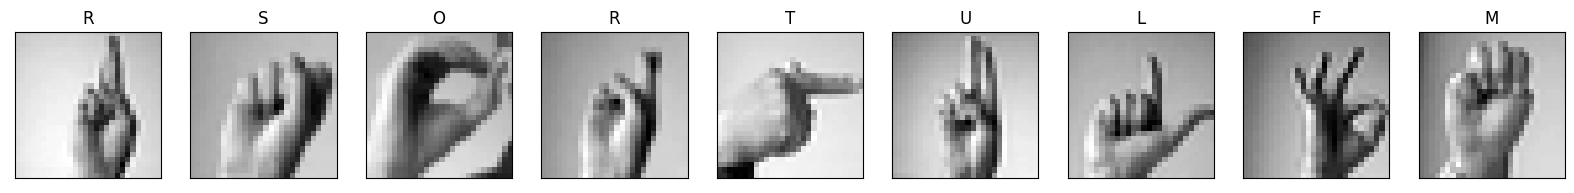

In [13]:
train = pd.read_csv("HW2_data/Q3_train.csv")
test = pd.read_csv("HW2_data/Q3_test.csv")

train = train.sample(frac=1)
train_len = int(len(train) * 90 / 100)
y_train = train.values[:train_len, 0].astype('uint8')
x_train = train.values[:train_len, 1:].astype('uint8')
y_validation = train.values[train_len:, 0].astype('uint8')
x_validation = train.values[train_len:, 1:].astype('uint8')
y_test = test.values[:, 0].astype('uint8')
x_test = test.values[:, 1:].astype('uint8')
n = 9

fig = plt.figure(figsize=(20, 5), facecolor='w')
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title(f"{chr(y_train[i] + ord('A'))}")
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [14]:
class NNModel(nn.Module):

    def __init__(self, input_size, output_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        )

    def forward(self, input_data):
        return self.layers(input_data)


class NNDModel(nn.Module):

    def __init__(self, input_size, output_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )

    def forward(self, input_data):
        return self.layers(input_data)


def learn(nn_model, algo, loss, xs, ys, batch, x_val, y_val):
    total_loss = 0
    current_result = 0

    nn_model.train(True)
    for i in range(0, len(ys), batch):
        x = torch.tensor(xs[i:min(len(ys), i + batch)], dtype=torch.float32)
        y = torch.tensor(ys[i:min(len(ys),i + batch)], dtype=torch.float32)
        algo.zero_grad()
        res = nn_model.forward(x)
        current_loss = loss(res, y.type(torch.LongTensor))
        current_loss.backward()

        algo.step()
        current_result += (np.argmax(res.data, axis=1) == y).sum().data
        total_loss += current_loss.data

    nn_model.train(False)
    res = nn_model.forward(x_val)
    val_acc = (np.argmax(res.data, axis=1) == y_val).sum().data / len(y_val)
    val_loss = loss(res, y_val.type(torch.LongTensor)).data


    return current_result.data / len(ys), total_loss, val_acc, val_loss

In [15]:
learning_rate = 0.001
momentum = 0.95
alph_size = 25
batch = 1024
n_epochs = 40

In [16]:
def learn_epochs(nn_model, algo, loss, x, y, batch, x_val, y_val):
    x_val = torch.tensor(x_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)
    loss_values = []
    results = []
    validation_losses = []
    validation_results = []

    model_state = None
    min_validation_loss = np.Inf

    for i in (k:=trange(n_epochs)):
        acc, total_loss, validation_acc, validation_loss = learn(nn_model, algo, loss, x, y, batch, x_val, y_val)
        k.set_description("train acc: %.2f" % acc)#, " train loss: %.2f" % total_loss, "val acc: %.2f" % validation_acc, "val loss: %.2f" % validation_loss)
        results.append(acc)
        loss_values.append(total_loss)
        validation_results.append(validation_acc)
        validation_losses.append(validation_loss)
        if validation_loss < min_validation_loss:
                min_validation_loss = validation_loss
                model_state = nn_model.state_dict()
    plt.plot(range(n_epochs), loss_values)
    plt.show()
    plt.plot(range(n_epochs), results)
    plt.show()
    plt.plot(range(n_epochs), validation_losses)
    plt.show()
    plt.plot(range(n_epochs), validation_results)
    plt.show()
    nn_model.load_state_dict(model_state)
    # return model_state

def final_test(nn_model, x, y):
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    res = nn_model.forward(x)
    current_loss = loss(res, y.type(torch.LongTensor))

    print('accuracy: ', (np.argmax(res.data, axis=1) == y).sum().data / len(y), ', loss: ', current_loss.data)

train acc: 1.00: 100%|██████████| 40/40 [06:03<00:00,  9.08s/it]


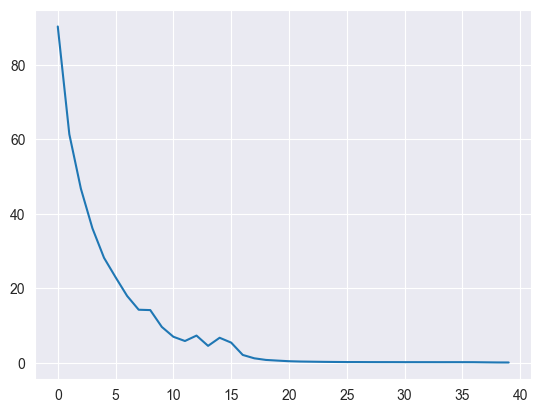

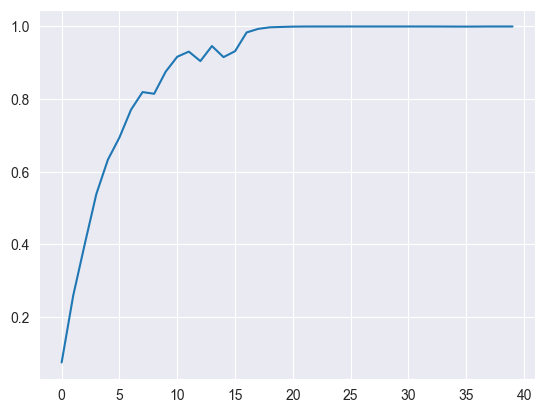

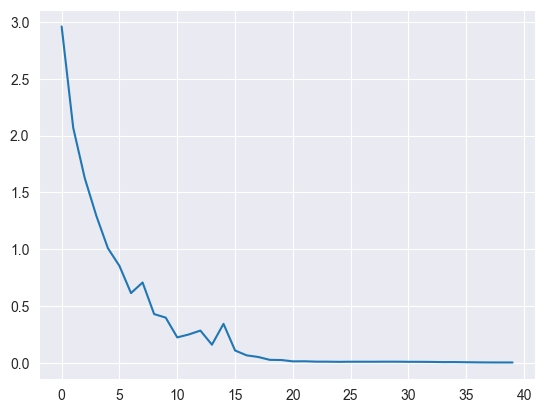

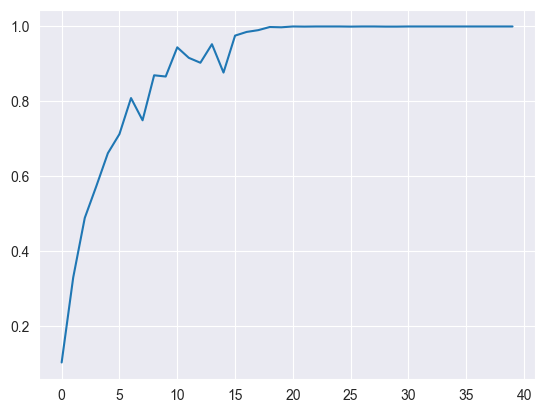

accuracy:  tensor(0.7922) , loss:  tensor(0.9904)


In [6]:
simple_nn_model = NNModel(x_train.shape[1], alph_size)
algo_sgd = SGD(simple_nn_model.parameters(), lr=learning_rate, momentum=momentum)
loss = nn.CrossEntropyLoss()

learn_epochs(simple_nn_model, algo_sgd, loss, x_train, y_train, batch, x_validation, y_validation)

final_test(simple_nn_model, x_test, y_test)

train acc: 1.00: 100%|██████████| 40/40 [03:29<00:00,  5.24s/it]


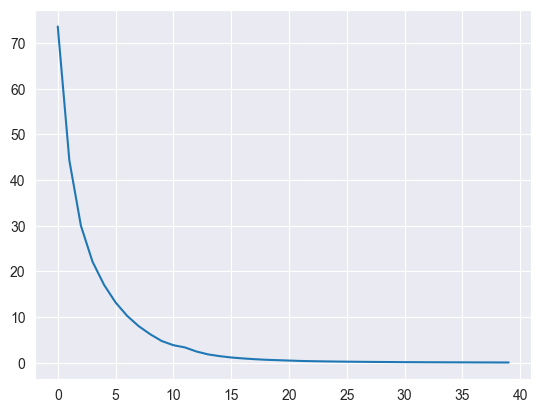

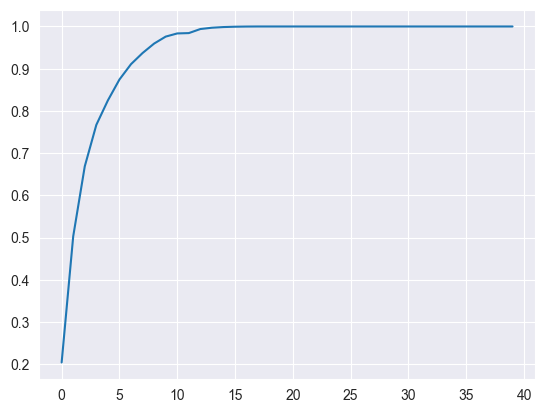

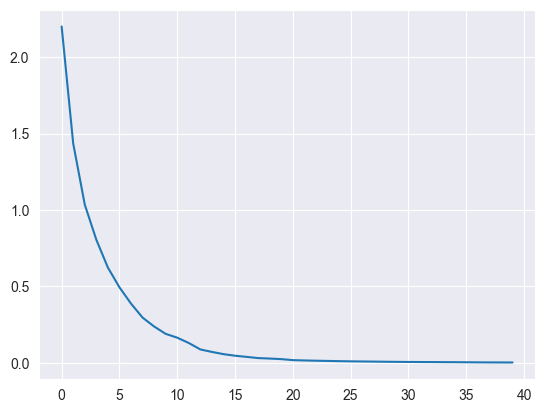

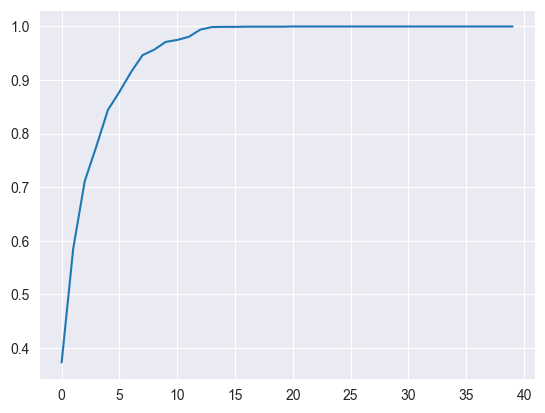

accuracy:  tensor(0.7758) , loss:  tensor(0.9446)


In [12]:
simple_nn_model = NNModel(x_train.shape[1], alph_size)
algo_adam = Adam(simple_nn_model.parameters(), lr=learning_rate / 10)
loss = nn.CrossEntropyLoss()

learn_epochs(simple_nn_model, algo_adam, loss, x_train, y_train, batch, x_validation, y_validation)

final_test(simple_nn_model, x_test, y_test)

train acc: 0.92: 100%|██████████| 40/40 [03:31<00:00,  5.30s/it]


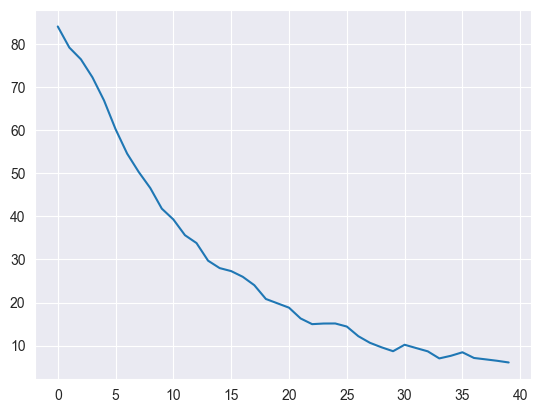

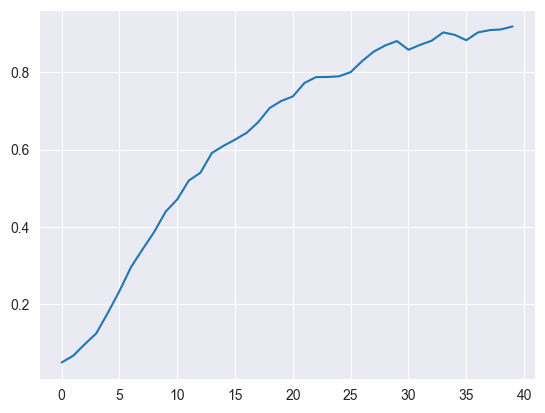

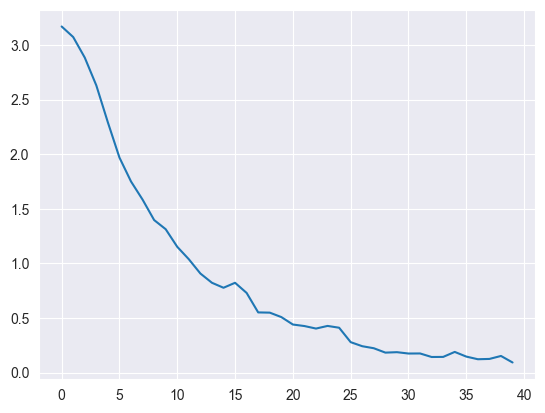

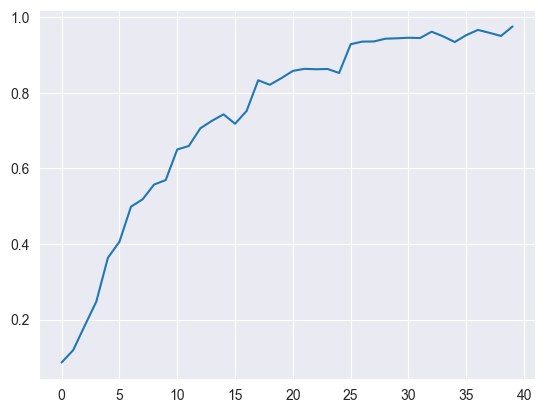

accuracy:  tensor(0.7610) , loss:  tensor(0.9590)


In [9]:
dropout_nn_model = NNDModel(x_train.shape[1], alph_size)

algo_sgd = SGD(dropout_nn_model.parameters(), lr=learning_rate, momentum=momentum)
loss = nn.CrossEntropyLoss()

learn_epochs(dropout_nn_model, algo_sgd, loss, x_train, y_train, batch, x_validation, y_validation)

final_test(dropout_nn_model, x_test, y_test)

train acc: 0.99: 100%|██████████| 40/40 [02:54<00:00,  4.36s/it]


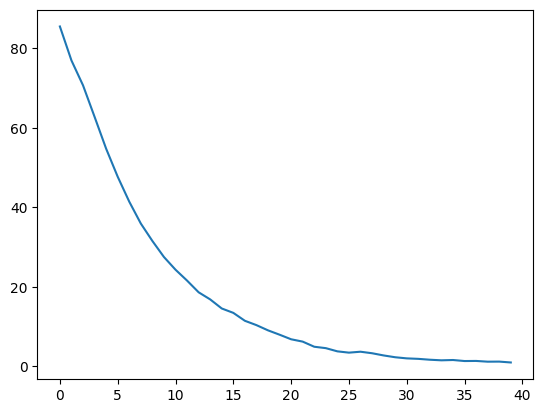

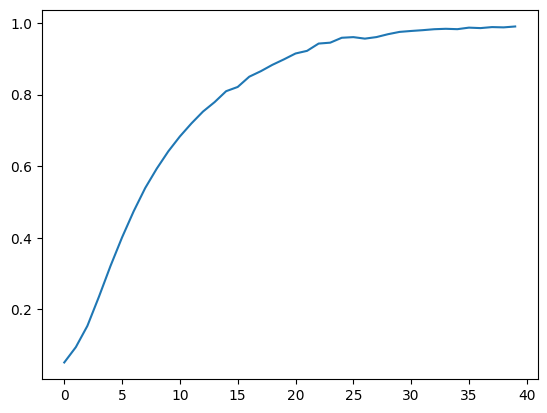

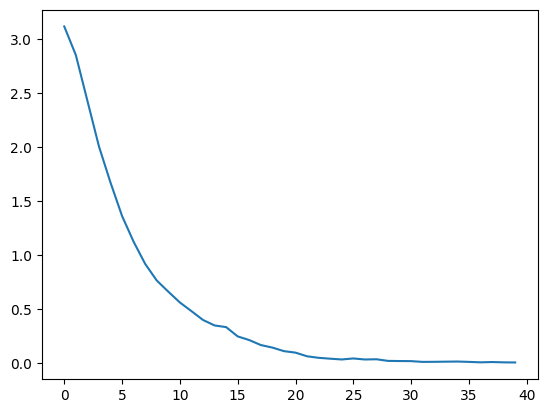

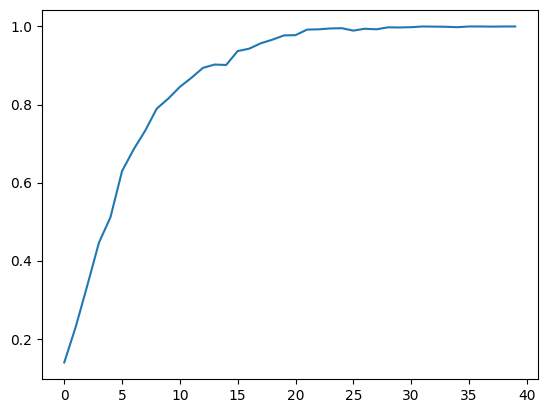

accuracy:  tensor(0.8182) , loss:  tensor(0.7802)


In [17]:
dropout_nn_model = NNDModel(x_train.shape[1], alph_size)

algo_adam = Adam(dropout_nn_model.parameters(), lr=learning_rate / 10)
loss = nn.CrossEntropyLoss()

learn_epochs(dropout_nn_model, algo_adam, loss, x_train, y_train, batch, x_validation, y_validation)

final_test(dropout_nn_model, x_test, y_test)

The best model is the model with dropout and Adam lost function. This model uses the following structure which is deeper and dropout acts like a regularization.

nn.Linear(input_size, 512),
nn.ReLU(),
nn.Linear(512, 512),
nn.ReLU(),
nn.Linear(512, 512),
nn.Dropout(p=0.5),
nn.ReLU(),
nn.Linear(512, 256),
nn.ReLU(),
nn.Linear(256, 128),
nn.Dropout(p=0.5),
nn.ReLU(),
nn.Linear(128, output_size)

In [25]:
import cv2 as cv
import numpy as np
img1 = cv.imread('img1.jpg')
img2 = cv.imread('img2.jpg')
img3 = cv.imread('img3.jpg')

gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
gray2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
gray3 = cv.cvtColor(img3, cv.COLOR_BGR2GRAY)

gray1 = cv.resize(gray1, (28, 28))
gray2 = cv.resize(gray2, (28, 28))
gray3 = cv.resize(gray3, (28, 28))

gray1 = (gray1 - np.mean(gray1)) / np.std(gray1)
gray2 = (gray2 - np.mean(gray2)) / np.std(gray2)
gray3 = (gray3 - np.mean(gray3)) / np.std(gray3)


gray1 = gray1.reshape((-1, 28 * 28))
gray2 = gray2.reshape((-1, 28 * 28))
gray3 = gray3.reshape((-1, 28 * 28))

x1 = torch.tensor(gray1, dtype=torch.float32)
res1 = dropout_nn_model.forward(x1)
print(np.argmax(res1.data))
x2 = torch.tensor(gray2, dtype=torch.float32)
res2 = dropout_nn_model.forward(x2)
print(np.argmax(res2.data))
x3 = torch.tensor(gray3, dtype=torch.float32)
res3 = dropout_nn_model.forward(x3)
print(np.argmax(res3.data))


tensor(20)
tensor(24)
tensor(16)
